In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
# data dir

data_dir = 'D:/thon/project/tourism/2022년/카드데이터'

# data load

card = pd.read_csv(data_dir + '/card_sports.csv') # load하는데 12초 소요
card = card.drop(['Unnamed: 0', 'gb3', 'v3'], axis = 1) # 스포츠활동 대분류인 gb3 칼럼과, 세부지역인 v3 칼럼은 제거
card = card.loc[card['gb3'] == '스포츠활동']
card['avg_spend'] = round(card['vlm'] / card['usec'], -1).astype(int)
index_to_drop = card.loc[(card['gb2'] == '스포츠용품구매') |
(card['gb2'] == '운동경기관람')].index
card = card.drop(index_to_drop, axis = 0)


## 추천시스템화

In [33]:
### 평균소비액 이상치 제거
# 평균소비액의 이상치 판단
q1, q3 = card['avg_spend'].quantile([0.25, 0.75])
iqr = q3 - q1
df = card.loc[card['avg_spend'] < q3 + 1.5 * iqr]
index_to_drop = df.loc[df['vlm'] == 0].index
df = df.drop(index_to_drop, axis = 0)

### 쓰지 않는 칼럼 제거
df.drop(['v2','ta_ym', 'daw_ccd_r', 'apv_ts_dl_tm_r', 'avg_spend'], axis = 1, inplace = True)

### 행 병합
# 나이, 성별, 거주지, 종목명 별로 병합
new_df = df.groupby(['v1', 'sex_ccd', 'cln_age_r', 'gb2']).sum()
new_df = new_df.reset_index() # 멀티인덱스 해제
new_df['avg_spend'] = round(new_df['vlm'] / new_df['usec'], -1).astype(int) # 건당 평균취급액 칼럼 추가
new_df['cln_age_r'] = new_df['cln_age_r'].astype(str)
new_df['as_person'] = new_df['v1'] + new_df['sex_ccd'] + new_df['cln_age_r']

### 새로운 칼럼 'rating' 생성
# new_df['avg_spend'] 5개 구간으로 나눠서 레이팅 지표로 삼기
bins = pd.cut(new_df['avg_spend'], 5, labels = ['1', '2', '3', '4', '5'])
new_df['rating'] = bins

### SVD에 사용할 칼럼만 다시 추출
recommend_df = new_df[['as_person', 'gb2', 'rating']]
recommend_df.columns = ['userId', 'sportsId', 'rating']
recommend_df['rating'].astype(int)

### 추천시스템 데이터셋
from surprise import Reader, Dataset # SVD model의 dataset

# 추천 시스템 패키지에 맞는 데이터프레임 생성 (Surprise에서 제시한 데이터 구조를 따라야함)
reader = Reader(rating_scale = (1, 5)) # SVD용 데이터구조 설정 1
data = Dataset.load_from_df(recommend_df[['userId', 'sportsId', 'rating']], reader = reader) # SVD용 데이터구조 설정 2

In [7]:
recommend_df

,userId,sportsId,rating
0,강원F20,골프,2
1,강원F20,레저스포츠,1
2,강원F20,스키,2
3,강원F20,자전거,1
4,강원F20,헬스,4
...,...,...,...
845,충북M60,골프,4
846,충북M60,레저스포츠,1
847,충북M60,스키,2
848,충북M60,자전거,4


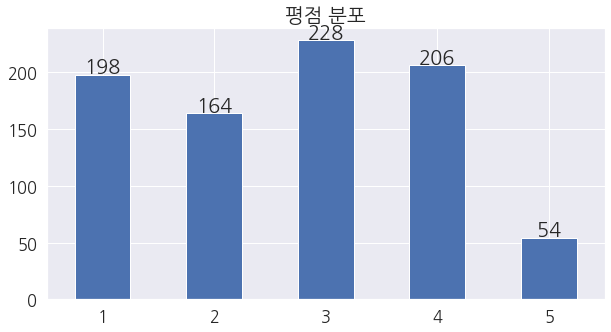

In [64]:
rating_graph = recommend_df['rating'].value_counts().sort_index()

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (10, 5))
ax = rating_graph.plot(kind = 'bar')
plt.xticks(rotation = 0)
ax.set_title('평점 분포', fontsize = 20)
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 2, height, ha = 'center', size = 20)

ax.set_xlabel('');  # semicolon suppresses text output

In [8]:
### 그리드서치로 SVD 모형의 최적의 파라미터 찾기
from surprise import SVD, accuracy # SVD model, 평가
from surprise.model_selection import GridSearchCV # GridSearch로 최적의 파라미터 찾기

param_grid = {'n_factors': [25, 50, 75,  100], 'lr_all': [0.5, 0.05], 'reg_all': [0.06, 0.04]}
gs = GridSearchCV(algo_class = SVD, measures = ['RMSE'], param_grid = param_grid)
gs.fit(data)

print('Best Score: ', gs.best_score['rmse'])
print('Best Parameters: ', gs.best_params['rmse'])

### 왜 할 때마다 달라지냐

Best Score:  0.7722320109842152
Best Parameters:  {'n_factors': 50, 'lr_all': 0.05, 'reg_all': 0.04}


In [10]:
### SVD 모델 적용하여 predict
from surprise import accuracy
from surprise.model_selection import train_test_split

model = SVD(n_factors = 100, lr_all = 0.05, reg_all = 0.04)
trainset, testset = train_test_split(data, test_size = .25)
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7886


0.7886118863395373

In [30]:
a = pd.DataFrame(testset)
a.columns = ['userId', 'sportsId', 'rating']
a['rating'] = a['rating'].astype(int)
a

,userId,sportsId,rating
0,부산F30,자전거,2
1,충북F60,레저스포츠,1
2,인천F30,헬스,4
3,울산F50,골프,4
4,전북M30,헬스,3
...,...,...,...
208,전북M30,레저스포츠,1
209,경기F60,스키,2
210,전북M30,스키,2
211,충남F60,골프,4


In [69]:
### 특정 집단 특성에 대한 추천 예시
# 예: 서울에 사는 20대 남성에게 가장 추천하는 스포츠는?

ex_id = '서울M20'
sports = ['골프', '레저스포츠', '스키', '자전거', '헬스']
ex_rating = []
print('<서울에 사는 20대 남성에게 추천하는 종목>')
for i, col in enumerate(sports):
    exp_rating = round(model.predict(ex_id, col).est, 1)
    ex_rating.append(exp_rating)
    print(col, '에 대한 예상 평점:', round(model.predict(ex_id, col).est, 1))

print('\n가장 추천하는 운동 종목은', sports[ex_rating.index(max(ex_rating))], ', 그 평점은', max(ex_rating), '로 예상됩니다.')
print('\n<실제 평점>')
recommend_df.loc[recommend_df['userId'] == '서울M20']

<서울에 사는 20대 남성에게 추천하는 종목>
골프 에 대한 예상 평점: 3.5
레저스포츠 에 대한 예상 평점: 1.1
스키 에 대한 예상 평점: 2.0
자전거 에 대한 예상 평점: 2.1
헬스 에 대한 예상 평점: 4.8

가장 추천하는 운동 종목은 헬스 , 그 평점은 4.8 로 예상됩니다.

<실제 평점>


,userId,sportsId,rating
425,서울M20,골프,2
426,서울M20,레저스포츠,1
427,서울M20,스키,2
428,서울M20,자전거,2
429,서울M20,헬스,5
